# 三层BP神经网络

In [3]:
import math
import random
import string

random.seed(0)

# 生成区间[a, b)内的随机数
def rand(a, b):
    return (b-a)*random.random() + a

# 生成大小 I*J 的矩阵，默认零矩阵 (当然，亦可用 NumPy 提速)
def makeMatrix(I, J, fill=0.0):
    m = []
    for i in range(I):
        m.append([fill]*J)
    return m

# 函数 sigmoid，这里采用 tanh，因为看起来要比标准的 1/(1+e^-x) 漂亮些
def sigmoid(x):
    return math.tanh(x)

# 函数 sigmoid 的派生函数, 为了得到输出 (即：y)
def dsigmoid(y):
    return 1.0 - y**2

class NN:
    ''' 三层反向传播神经网络 '''
    def __init__(self, ni, nh, no):
        # 输入层、隐藏层、输出层的节点（数）
        self.ni = ni + 1 # 增加一个偏差节点
        self.nh = nh
        self.no = no

        # 激活神经网络的所有节点（向量）
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # 建立权重（矩阵）
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        # 设为随机值
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)

        # 最后建立动量因子（矩阵）
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)

    def update(self, inputs):
        if len(inputs) != self.ni-1:
            raise ValueError('与输入层节点数不符！')

        # 激活输入层
        for i in range(self.ni-1):
            #self.ai[i] = sigmoid(inputs[i])
            self.ai[i] = inputs[i]

        # 激活隐藏层
        for j in range(self.nh):
            sum = 0.0
            for i in range(self.ni):
                sum = sum + self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum)

        # 激活输出层
        for k in range(self.no):
            sum = 0.0
            for j in range(self.nh):
                sum = sum + self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum)

        return self.ao[:]

    def backPropagate(self, targets, N, M):
        ''' 反向传播 '''
        if len(targets) != self.no:
            raise ValueError('与输出层节点数不符！')

        # 计算输出层的误差
        output_deltas = [0.0] * self.no
        for k in range(self.no):
            error = targets[k]-self.ao[k]
            output_deltas[k] = dsigmoid(self.ao[k]) * error

        # 计算隐藏层的误差
        hidden_deltas = [0.0] * self.nh
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error = error + output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # 更新输出层权重
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k]*self.ah[j]
                self.wo[j][k] = self.wo[j][k] + N*change + M*self.co[j][k]
                self.co[j][k] = change
                #print(N*change, M*self.co[j][k])

        # 更新输入层权重
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] = self.wi[i][j] + N*change + M*self.ci[i][j]
                self.ci[i][j] = change

        # 计算误差
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5*(targets[k]-self.ao[k])**2
        return error

    def test(self, patterns):
        for p in patterns:
            print(p[0], '->', self.update(p[0]))

    def weights(self):
        print('输入层权重:')
        for i in range(self.ni):
            print(self.wi[i])
        print()
        print('输出层权重:')
        for j in range(self.nh):
            print(self.wo[j])

    def train(self, patterns, iterations=1000, N=0.5, M=0.1):
        # N: 学习速率(learning rate)
        # M: 动量因子(momentum factor)
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets, N, M)
            if i % 100 == 0:
                print('误差 %-.5f' % error)


def demo():
    # 一个演示：教神经网络学习逻辑异或（XOR）------------可以换成你自己的数据试试
    pat = [
        [[0,0], [0]],
        [[0,1], [1]],
        [[1,0], [1]],
        [[1,1], [0]]
    ]

    # 创建一个神经网络：输入层有两个节点、隐藏层有两个节点、输出层有一个节点
    n = NN(2, 2, 1)
    # 用一些模式训练它
    n.train(pat)
    # 测试训练的成果（不要吃惊哦）
    n.test(pat)
    # 看看训练好的权重（当然可以考虑把训练好的权重持久化）
    #n.weights()
    
    
if __name__ == '__main__':
    demo()

误差 0.94250
误差 0.04287
误差 0.00348
误差 0.00164
误差 0.00106
误差 0.00078
误差 0.00125
误差 0.00053
误差 0.00044
误差 0.00038
[0, 0] -> [0.03668584043139609]
[0, 1] -> [0.9816625517128087]
[1, 0] -> [0.9815264813097478]
[1, 1] -> [-0.03146072993485337]


[神经网络学习(3)BP神经网络](https://blog.csdn.net/qq_42633819/article/details/82903871)

# 二层神经网络

In [8]:
# -*- coding:utf-8 -*-
#! python3
import numpy as np
#sigmoid function
def nonlin(x, deriv = False):
    if(deriv == True):
        return x*(1-x)
    else:
        return 1/(1+np.exp(-x))
#input dataset
x = np.array([
    [0,0,1],
    [0,1,1],
    [1,0,1],
    [1,1,1]])
#output dataset
y = np.array([[0,0,1,1]]).T
np.random.seed(1)
#init weight value
syn0 = 2*np.random.random((3,1))-1
print ("测试结果：")
for iter in range(100000):
    l0 = x       #the first layer,and the input layer
    l1 = nonlin(np.dot(l0,syn0)) #the second layer,and the output layer
    l1_error = y-l1
    l1_delta = l1_error*nonlin(l1,True)
    syn0 += np.dot(l0.T, l1_delta)
print("Outout after Training:")
print(l1)

测试结果：
Outout after Training:
[[0.00301758]
 [0.00246109]
 [0.99799161]
 [0.99753723]]


这里，
- l0:输入层
- l1:输出层
- syn0:初始权值
- l1_error:误差
- l1_delta:误差校正系数
- func nonlin:sigmoid函数

# 三层神经网络

In [5]:
# -*- coding:utf-8 -*-
#! python3
import numpy as np
def nonlin(x, deriv = False):
    if(deriv == True):
        return x*(1-x)
    else:
        return 1/(1+np.exp(-x))
#input dataset
X = np.array([
    [0,0,1],
    [0,1,1],
    [1,0,1],
    [1,1,1]])
#output dataset
y = np.array([[0,1,1,0]]).T
syn0 = 2*np.random.random((3,4)) - 1 #the first-hidden layer weight value
syn1 = 2*np.random.random((4,1)) - 1 #the hidden-output layer weight value
print ("测试结果：")
for j in range(60000):
    l0 = X      #the first layer,and the input layer
    l1 = nonlin(np.dot(l0,syn0)) #the second layer,and the hidden layer
    l2 = nonlin(np.dot(l1,syn1)) #the third layer,and the output layer
    l2_error = y-l2  #the hidden-output layer error
    if(j%10000) == 0:
        print("Error:"+str(np.mean(l2_error)))
    l2_delta = l2_error*nonlin(l2,deriv = True)
    l1_error = l2_delta.dot(syn1.T)  #the first-hidden layer error
    l1_delta = l1_error*nonlin(l1,deriv = True)
    syn1 += l1.T.dot(l2_delta)
    syn0 += l0.T.dot(l1_delta)
print("outout after Training:")
print(l2)

测试结果：
Error:-0.011159308057659939
Error:-0.0006960140488302597
Error:-0.00048340703705386815
Error:-0.00039386976564297917
Error:-0.00034149882912280164
Error:-0.00030610659285774835
outout after Training:
[[0.00395374]
 [0.99568925]
 [0.9967036 ]
 [0.00477395]]


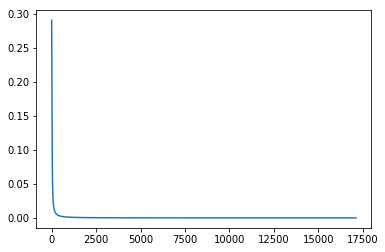

[0.0131328  0.98680876]
17126
9.999213376027056e-06


In [16]:
import numpy as np

import matplotlib.pyplot as plt

import math

%matplotlib inline

x=np.array([0.05,0.10])

y=np.array([[0.15,0.25],[0.2,0.3]])

y1=np.array([[0.4,0.5],[0.45,0.55]])
r=np.array([0.01,0.99])

b=0.35

b1=0.6

q=0.5#学习率

def neth(x,y,b):

    return np.dot(x,y)+b

def outh():

    outh=[]

    for i in range(len(y[0])):

        a=1/(math.exp(-neth(x,y,b)[i])+1)

        outh.append(a)

    return np.array(outh)

def neto():

    return np.dot(outh(),y1)+b1

def outo():

    outo=[]

    for i in range(len(y1[0])):

        a=1/(math.exp(-neto()[i])+1)
        outo.append(a)

    return np.array(outo)
o=0
O=[]
result=[]
#梯度下降
while True:
  o=o+1
  dif=[[0,0],[0,0]]
  dif1=[[0,0],
      [0,0]]
  a=0
#对w5-w8进行求导
  for i in range(len(y1)):
    for j in range(len(y1[i])):
      dif1[i][j]=(-(r[j]-outo()[j]))*(outo()[j]*(1-outo()[j]))*(outh()[i])
      y1[i][j]=y1[i][j]-q*dif1[i][j]
#对w1-w4进行求导
  for i in range(len(y)):
    for j in range(len(outo())):
      a=a+(-(r[j]-outo()[j]))*outo()[j]*(1-outo()[j])*y1[i][j]
    for k in range(len(y[i])):
      dif[i][k]=a*(outh()[k]*(1-outh()[k]))*x[i]
      y[i][k]=y[i][k]-q*dif[i][k]
  e=np.sum((r-outo())**2/2)#总误差
  result.append(e)
  O.append(o)
  if e<0.00001:
    break
plt.plot(O,result)
plt.show()
print(outo())
print(o)
print(e)

# 自练习代码书写

## 只运行一次神经网络

In [22]:
#结合推导公式的代码,旨在建立一个3层神经网络(输入层节点数为2,隐含层节点数为2,输出层节点数为2)
#引库
import numpy as np
import matplotlib.pyplot as plt
#嵌入图片
%matplotlib inline

#输入层数据
i = [0.05,0.10]
#输入层到隐含层的权重
w1 = [0.15,0.20,0.25,0.30]
#隐含层到输出层的权重
w2 = [0.40,0.45,0.50,0.55]
#输入层到隐含层的偏置
b1 = 0.35
#隐含层到输出层的偏置
b2 = 0.6
#原始的结果
y = [0.01,0.99]
#为第一二层运行的结果建立列表
out_one = []
out_two = []

out_three = []
out_four =[]
#设置学习率
alpha = 0.1
#为我们程序输出的结果建个列表存放数据
y_pre = []

#-----------前向传播-------------
#输入层--->隐含层
net1 = i[0]*w1[0] + b1
net2 = i[1]*w1[1] + b1
out1 = 1/(1+np.exp(-net1))
out_one.append(out1)
out2 = 1/(1+np.exp(-net2))
out_one.append(out2)
#隐含层--->输出层
net3 = out_one[0]*w2[0] + b1
net4 = out_one[1]*w2[1] + b1
out3 = 1/(1+np.exp(-net3))
out_two.append(out3)
out4 = 1/(1+np.exp(-net4))
out_two.append(out4)
#-------------完成----------------  
  
'''  
----------计算误差---------------
Etotal = E1 + E2
E = 0.5*(target - out)^2
'''
E = 0.5*(y[0] - out_two[0])**2 + 0.5*(y[1] - out_two[1])**2
#-------------完成-----------------


#----------反向传播---------------
#输出层--->隐含层
pd5 = -(y[0] - out_two[0])*out_two[0]*(1-out_two[0])*out_one[0]
pd6 = -(y[0] - out_two[0])*out_two[0]*(1-out_two[0])*out_one[1]
pd7 = -(y[1] - out_two[1])*out_two[1]*(1-out_two[1])*out_one[0]
pd8 = -(y[1] - out_two[1])*out_two[1]*(1-out_two[1])*out_one[1]
#第二层权值更新
w2[0] = w2[0] - alpha*pd5
w2[1] = w2[1] - alpha*pd6
w2[2] = w2[2] - alpha*pd7
w2[3] = w2[3] - alpha*pd8

#隐含层--->输入层
F1 = -(y[0] - out_two[0])*out_two[0]*(1-out_two[0])
F2 = -(y[1] - out_two[1])*out_two[1]*(1-out_two[1])
pd1 = (F1*w2[0] + F2*w2[2])*out_one[0]*(1 - out_one[0])*i[0]
pd2 = (F1*w2[0] + F2*w2[2])*out_one[0]*(1 - out_one[0])*i[1]
pd3 = (F1*w2[1] + F2*w2[1])*out_one[1]*(1 - out_one[1])*i[0]
pd4 = (F1*w2[1] + F2*w2[1])*out_one[1]*(1 - out_one[1])*i[1]
#第一层权值更新
w1[0] = w1[0] - alpha*pd1
w1[1] = w1[1] - alpha*pd2
w1[2] = w1[2] - alpha*pd3
w1[3] = w1[3] - alpha*pd4
#-----------完成-------------------

print(w1)
print(w2)

#-----------二次前向传播-------------
#输入层--->隐含层
net5 = i[0]*w1[0] + b1
net6 = i[1]*w1[1] + b1
out5 = 1/(1+np.exp(-net5))
out_three.append(out5)
out6 = 1/(1+np.exp(-net6))
out_three.append(out6)
#隐含层--->输出层
net7 = out_one[0]*w2[0] + b1
net8 = out_one[1]*w2[1] + b1
out7 = 1/(1+np.exp(-net7))
out_four.append(out7)
out8 = 1/(1+np.exp(-net8))
out_four.append(out8)
#-------------完成----------------  

print(out_four)

[0.1499785312076401, 0.19995706241528025, 0.24996389283843035, 0.2999277856768607]
[0.3914517132698702, 0.4414077852191141, 0.5045642655167523, 0.5545877204257433]
[0.6411465421456791, 0.6481858933602679]


## 运行一万次神经网络

In [23]:
#结合推导公式的代码,旨在建立一个3层神经网络(输入层节点数为2,隐含层节点数为2,输出层节点数为2)
#引库
import numpy as np
import matplotlib.pyplot as plt
#嵌入图片
%matplotlib inline

#输入层数据
i = [0.05,0.10]
#输入层到隐含层的权重
w1 = [0.15,0.20,0.25,0.30]
#隐含层到输出层的权重
w2 = [0.40,0.45,0.50,0.55]
#输入层到隐含层的偏置
b1 = 0.35
#隐含层到输出层的偏置
b2 = 0.6
#原始的结果
y = [0.01,0.99]
#为第一二层运行的结果建立列表
out_one = []
out_two = []

out_three = []
out_four =[]
#设置学习率
alpha = 0.1

count = 0

while True:
  #-----------前向传播-------------
  #输入层--->隐含层
  net1 = i[0]*w1[0] + b1
  net2 = i[1]*w1[1] + b1
  out1 = 1/(1+np.exp(-net1))
  out_one.append(out1)
  out2 = 1/(1+np.exp(-net2))
  out_one.append(out2)
  #隐含层--->输出层
  net3 = out_one[0]*w2[0] + b1
  net4 = out_one[1]*w2[1] + b1
  out3 = 1/(1+np.exp(-net3))
  out_two.append(out3)
  out4 = 1/(1+np.exp(-net4))
  out_two.append(out4)
  #-------------完成----------------  

  '''  
  ----------计算误差---------------
  Etotal = E1 + E2
  E = 0.5*(target - out)^2
  '''
  E = 0.5*(y[0] - out_two[0])**2 + 0.5*(y[1] - out_two[1])**2
  #-------------完成-----------------


  #----------反向传播---------------
  #输出层--->隐含层
  pd5 = -(y[0] - out_two[0])*out_two[0]*(1-out_two[0])*out_one[0]
  pd6 = -(y[0] - out_two[0])*out_two[0]*(1-out_two[0])*out_one[1]
  pd7 = -(y[1] - out_two[1])*out_two[1]*(1-out_two[1])*out_one[0]
  pd8 = -(y[1] - out_two[1])*out_two[1]*(1-out_two[1])*out_one[1]
  #第二层权值更新
  w2[0] = w2[0] - alpha*pd5
  w2[1] = w2[1] - alpha*pd6
  w2[2] = w2[2] - alpha*pd7
  w2[3] = w2[3] - alpha*pd8

  #隐含层--->输入层
  F1 = -(y[0] - out_two[0])*out_two[0]*(1-out_two[0])
  F2 = -(y[1] - out_two[1])*out_two[1]*(1-out_two[1])
  pd1 = (F1*w2[0] + F2*w2[2])*out_one[0]*(1 - out_one[0])*i[0]
  pd2 = (F1*w2[0] + F2*w2[2])*out_one[0]*(1 - out_one[0])*i[1]
  pd3 = (F1*w2[1] + F2*w2[1])*out_one[1]*(1 - out_one[1])*i[0]
  pd4 = (F1*w2[1] + F2*w2[1])*out_one[1]*(1 - out_one[1])*i[1]
  #第一层权值更新
  w1[0] = w1[0] - alpha*pd1
  w1[1] = w1[1] - alpha*pd2
  w1[2] = w1[2] - alpha*pd3
  w1[3] = w1[3] - alpha*pd4
  #-----------完成-------------------

  #print("第一层四个权值更新为:",w1)
  #print("第二层四个权值更新为:",w2)

  #-----------二次前向传播-------------
  #输入层--->隐含层
  net5 = i[0]*w1[0] + b1
  net6 = i[1]*w1[1] + b1
  out5 = 1/(1+np.exp(-net5))
  out_three.append(out5)
  out6 = 1/(1+np.exp(-net6))
  out_three.append(out6)
  #隐含层--->输出层
  net7 = out_one[0]*w2[0] + b1
  net8 = out_one[1]*w2[1] + b1
  out7 = 1/(1+np.exp(-net7))
  out_four.append(out7)
  out8 = 1/(1+np.exp(-net8))
  out_four.append(out8)
  #-------------完成----------------  
  count += 1
  #print("再一次前项传播的结果为:",out_four)
  if count == 10000:
    break
print("最终O1的结果为:",out_three[9999])
print("最终O2的结果为:",out_four[9999])

最终O1的结果为: 0.9943957071639503
最终O2的结果为: 1.707242813286684e-11


<function matplotlib.pyplot.show(*args, **kw)>

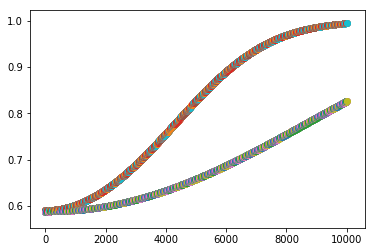

In [26]:
for i in range(10000):
    plt.scatter(i,out_three[i])
plt.show

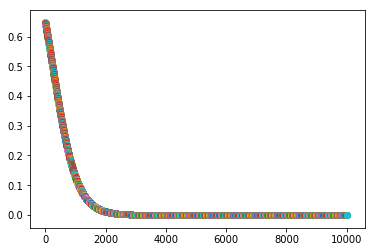

In [25]:
for j in range(10000):
    plt.scatter(j,out_four[j])
plt.show()